In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
sys.path.insert(1, os.path.abspath('../'))
sys.path.insert(1, os.path.abspath('../../..'))

from modules.plots import set_aspect
from modules.utils import save_descriptive_stats,save_variables, significance_asterisk
from modules.config import data_reports_path, figpath, pre_color, post_color, default_color

In [2]:
analysis = 'times'

# Load dataset from Excel file containing activity times and pre/post measures
data = pd.read_excel(Path('../../data/processed/absolute_times_data.xlsx'))

# Time-of-day activity bins
bin_columns = ['activity-00:00-05:59', 'activity-06:00-11:59', 
               'activity-12:00-17:59', 'activity-18:00-23:59']

# Generate simpler labels for the x-axis by removing the 'activity-' prefix
bin_labels = [col.replace('activity-', '') for col in bin_columns]


### Fig. A9D - Plot the selection of each bin in the pre- and post-assessments. 

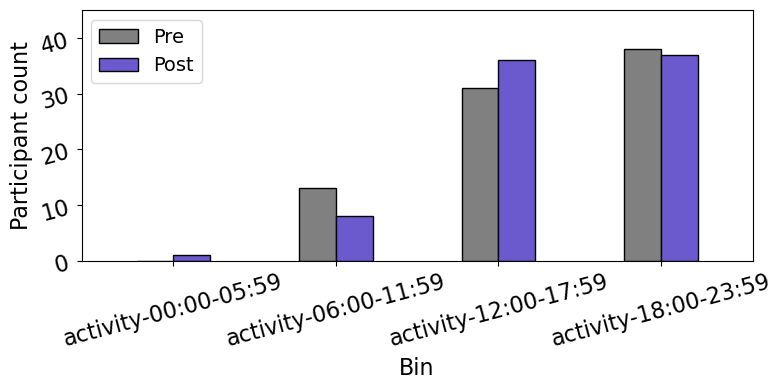

In [3]:
from modules.plots import plot_bin_selection
plot_bin_selection(data,bin_columns,analysis,name='survey')

### Fig. 6A - Plot the selected bins in order of their objective rankings.

Sort the bins for each participant based on the objective probability of the bin. Then, assess the selection of the bins in the pre- and post-feedback self-reports. 

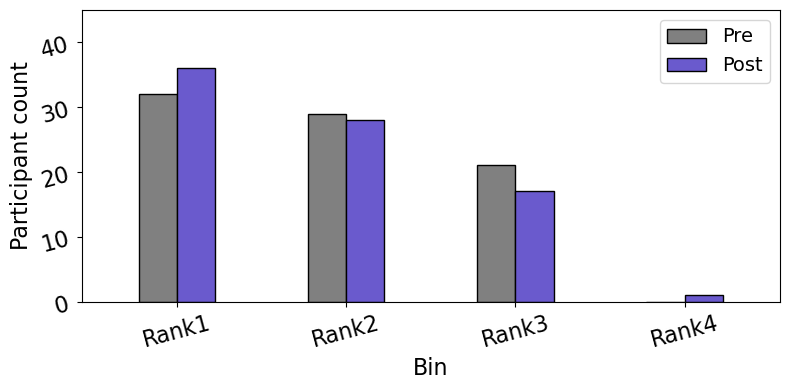

In [4]:
# Initialize lists to store binary responses by objective bin rank
# Sort by ranks (1= highest probability bin, etc.)

objective_bins_pre = {f'Rank{i}': [] for i in range(1, len(bin_columns)+1)}
objective_bins_post = {f'Rank{i}': [] for i in range(1, len(bin_columns)+1)}

# Iterate over each participant's data
for index, row in data.iterrows():
    # Get the model's writing probabilities for each bin for this participant
    speed_p = row[bin_columns]
    
    # Sort bins by writing probability in descending order
    sorted_series = speed_p.sort_values(ascending=False)
    sorted_columns = sorted_series.index.tolist()
    
    # Assign pre/post responses to bins ranked by objective model probability
    for ind, col in enumerate(sorted_columns):
        objective_bins_pre[f'Rank{ind+1}'].append(row[f'{col}_pre'])
        objective_bins_post[f'Rank{ind+1}'].append(row[f'{col}_post'])

# Convert dictionaries to DataFrames
df_pre = pd.DataFrame(objective_bins_pre)
df_post = pd.DataFrame(objective_bins_post)

# Rename columns to indicate pre/post
df_pre.columns = [f'{col}_pre' for col in df_pre.columns]
df_post.columns = [f'{col}_post' for col in df_post.columns]

# Concatenate along columns
ranks_df = pd.concat([df_pre, df_post], axis=1)
ranks = ['Rank1', 'Rank2', 'Rank3', 'Rank4']

plot_bin_selection(ranks_df,ranks,analysis,name='obj')

### Plot the overall probability of being active within a certain bin for the entire sample. The shaded areas are the standard deviations. 

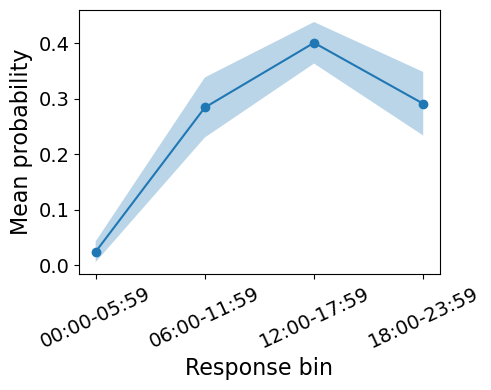

In [6]:
# Compute the mean and standard deviation of activity probabilities across all participants for each time bin
means = data[bin_columns].mean(axis=0)
std = data[bin_columns].std(axis=0)

# Initialize figure and axis for plotting
fig, ax = plt.subplots(figsize=(5, 4))

# Plot the mean probability values with markers for each bin
ax.plot(range(len(bin_labels)), means, 'o-')

# Add a shaded area representing standard deviation from the mean
ax.fill_between(range(len(bin_labels)), means - std, means + std, alpha=0.3)

# Set axis labels
ax.set_ylabel('Mean probability', fontsize=16)
ax.set_xlabel('Response bin', fontsize=16)

# Set custom tick positions and labels using formatted bin names
ax.set_xticks(range(len(bin_labels)))
ax.set_xticklabels(bin_labels, rotation=25)

# Format tick label size
ax.tick_params(axis='both', which='major', labelsize=14)

# Set background color and finalize layout
fig.patch.set_facecolor('white')
fig.tight_layout()

# Save figure in PNG and SVG formats
fig.savefig(Path(f'{figpath}/{analysis}-bin-obj-prob.png'))
fig.savefig(Path(f'{figpath}/{analysis}-bin-obj-prob.svg'))

for col in bin_columns:
    save_variables(data_reports_path, f'{analysis}-{col}-mean-obj', int(means[col]*100))